# 3D wedges

Let's try to extend wedges to 3D, especially for the binary (2-lithology) wedge case.

**Watch out, this is all rather experimental.**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

(2.0, 0.0)

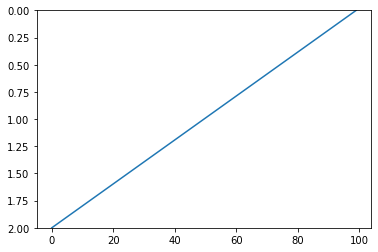

In [5]:
left, right = 2, 0
y = np.linspace(left, right, 100)
plt.plot(y)
plt.ylim(2, 0)

(2.0, 0.0)

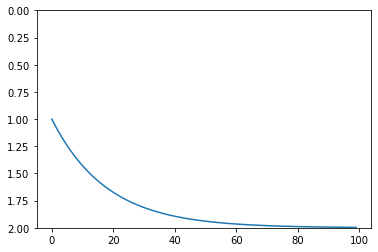

In [59]:
def power(start, stop, num):
    """
    Nonlinear space following a power function.
    """
    x = np.linspace(0, 8, num)
    y = 1 - 2**-x
    return min(start, stop) + abs(stop-start) * y

left, right = 1, 2
y = power(left, right, 100)
plt.plot(y)
plt.ylim(right, 0)

(2.0, 0.0)

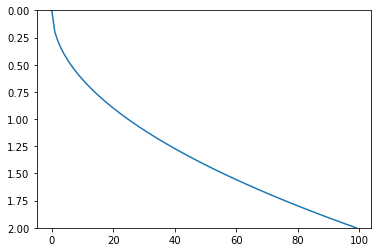

In [60]:
def root(start, stop, num):
    """
    Nonlinear space following a sqrt function.
    """
    x = np.linspace(0, 1, num)
    y = np.sqrt(x)
    return min(start, stop) + abs(stop-start) * y

left, right = 0, 2
y = root(left, right, 100)
plt.plot(y)
plt.ylim(right, 0)

(2.0, 0.0)

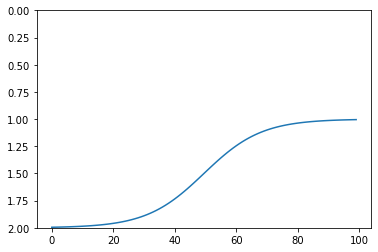

In [53]:
def sigmoid(start, stop, num):
    """
    Nonlinear space following a logistic function.
    
    The function is asymptotic; the parameters used in the sigmoid
    gets within 0.5% of the target thickness in a wedge increasing
    from 0 to 2x the original thickness.
    """
    x = np.linspace(-5.293305, 5.293305, num)
    return start + (stop-start) / (1 + np.exp(-x))

left, right = 2, 1
y = sigmoid(left, right, 100)
plt.plot(y)
plt.ylim(2, 0)

In [9]:
def pad_func(before, after):
    """
    Padding function. Operates on vector *in place*,
    as per the np.pad documentation.
    """
    def pad_with(x, pad_width, iaxis, kwargs):
        x[:pad_width[0]] = before[-pad_width[0]:]
        x[-pad_width[1]:] = after[:pad_width[1]]
        return
    return pad_with

In [10]:
import scipy.ndimage as sn

def get_strat(strat, thickness, mode='stretch', kind='nearest', position=1, wedge=None, zoom_mode='nearest'):
    """
    Take a 'stratigraphy' (either an int, a float, a tuple or list of ints,
    or a list-like of floats) and expand or compress it to the
    required thickness.
    
    'mode' can be 'stretch' or 'crop'
    
    `kind` can be 'nearest', 'linear', 'quadratic', or 'cubic'.
    """
    orders = {'nearest': 0, 'linear': 1, 'quadratic': 2, 'cubic': 3}
    order = orders.get(kind, 0)
    
    if isinstance(strat, int) and order==0:
        out = np.repeat([strat], thickness)
    elif isinstance(strat, float) and order==0:
        out = np.repeat([strat], thickness)
    elif isinstance(strat[0], int) and order==0:
        out = np.repeat(strat, int(round(thickness/len(strat))))
    else:
        if position == 0:
            wedge_zoom = wedge[1]/len(wedge[0])
            strat = strat[-int(thickness/wedge_zoom):]
        elif position == -1:
            wedge_zoom = wedge[1]/len(wedge[0])
            strat = strat[:int(thickness/wedge_zoom)]
        zoom = thickness / len(strat)
        out = sn.zoom(strat, zoom=zoom, order=order, mode=zoom_mode)
       
    # Guarantee correct length by adjusting bottom layer.
    missing = int(np.ceil(thickness - out.size))
    if out.size > 0 and missing > 0:
        out = np.pad(out, [0, missing], mode='edge')
    elif out.size > 0 and missing < 0:
        out = out[:missing]

    return out

get_strat((0, 1), 60)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [11]:
thick = 25
s = get_strat((0, 1, 0, 1, 0), thick)
assert s.size == thick
s

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0])

In [12]:
def get_conforming(strat, thickness, conformance):
    """
    Function to deal with top and bottom conforming wedges.
    """
    thickness = int(np.ceil(thickness))
    if thickness == 0:
        return np.array([])
    if strat.size == thickness:
        return strat
    elif strat.size > thickness:
        return strat[:thickness] if conformance == 'top' else strat[-thickness:]
    else:
        if conformance == 'top':
            return np.pad(strat, [0, thickness-strat.size], mode='wrap')
        else:
            return np.pad(strat, [thickness-strat.size, 0], mode='wrap')
    return

(180, 40)


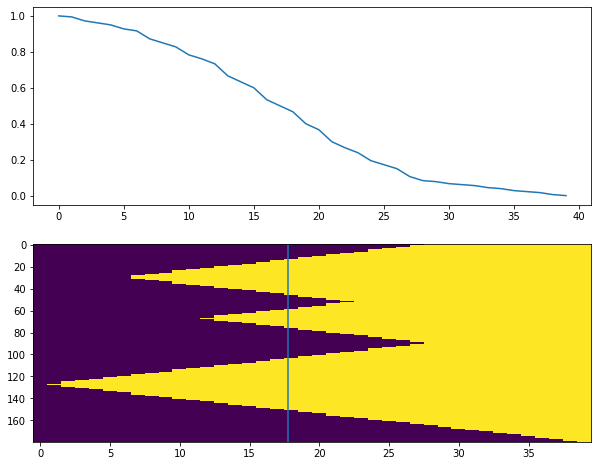

In [13]:
import scipy.ndimage.morphology as morph

def get_subwedges(target, breadth):
    """
    For a binary target (the reference trace of a wedge),
    create the range of net:gross subwedges. We do this
    with binary morphologies in the following way:
    
    - Erode the 'secondary' component (whatever appears
      second in the target array) one step at a time,
      until there is nothing left and the resulting
      trace contains only the primary.
    - Dilate the secondary component until there is
      nothing left of the primary and the resulting trace
      contains only the secondary.
    - Arrange the traces in order, starting with all
      primary, and ending in all secondary. The target
      trace will be somewhere in between, but not
      necessarily in the middle.
    
    Returns a 2D array with one target wedge trace per
    section.
    
    Args:
        target (array): A 1D array length N, the 'reference'
            trace for the wedge. The reference trace has
            thickness '1' in the wedge model. This trace must
            be 'binary' — i.e. it must contain exactly 2
            unique values.
        breadth (int): How many new reference traces should
            be in the output.

    Returns:
        tuple (ndarray, ndarray, int). The ndarray has shape
            N x breadth. It represents one target wedge trace
            per section in 'breadth'. The integer is the
            position of the target trace in the ndarray's
            second dimension.
    """
    try:
        components = a, b = np.unique(target)
    except ValueError as e:
        raise ValueError("Must be a binary (2-component) wedge.")

    out = [target]

    temp = target.copy()
    while b in temp:
        ero = morph.binary_erosion(temp==b)
        temp = components[ero.astype(int)]
        out.append(temp)

    out = out[::-1]
    ref = len(out)
    
    temp = target.copy()
    while a in temp:
        dil = morph.binary_dilation(temp==b)
        temp = components[dil.astype(int)]
        out.append(temp)

    arr_ = np.array(out).T
    h, w = arr_.shape
    arr = sn.zoom(arr_, zoom=(1, breadth/w), mode='nearest')
    
    ng = np.divide(np.sum(arr==a, axis=0), target.size)
    
    return arr, ng, ref * breadth / w

layer2 = np.repeat([2, 3, 3, 2, 3, 2, 2, 3, 3, 3, 2, 2], repeats=15)
arr, ng, ref = get_subwedges(layer2, breadth=40)

fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(10, 8))
ax0.plot(ng)
ax1.imshow(arr, interpolation='none', aspect='auto')
ax1.axvline(ref)

print(arr.shape)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import warnings


def wedge(depth=(30, 40, 30),
          width=(10, 80, 10),
          breadth=None,
          strat=(0, 1, 2),
          thickness=(0.0, 1.0),
          mode='linear',
          conformance='both',
         ):
    """
    Generate a wedge model.
    
    Args:
        depth (int or tuple): The vertical size of the model. If a 3-tuple, then
            each element corresponds to a layer. If an integer, then each layer
            of the model will be 1/3 of the thickness. Note that if the 'right'
            wedge thickness is more than 1, then the total thickness will be
            greater than this value.
        width (int or tuple): The width of the model. If a 3-tuple, then each
            element corresponds to a 'zone' (left, middle, right). If an integer,
            then the zones will be 10%, 80% and 10% of the width, respectively.
        breadth (None or int): Not implemented. Raises an error.
        strat (tuple): Stratigraphy above, in, and below the wedge. This is the
            'reference' stratigraphy. If you give integers, you get 'solid' layers
            containing those numbers. If you give arrays, you will get layers of
            those arrays, expanded or squeezed into the layer thicknesses implied
            in `depth`. 
        thickness (tuple): The wedge thickness on the left and on the right.
            Default is (0.0, 1.0) so the wedge will be thickness 0 on the left
            and the wedge thickness specified in the depth argument on the right.
            If the thickness are equal, you'll have a flat, layer-cake model.
        mode (str or function): What kind of interpolation to use. Default:
            'linear'. Other options are 'sigmoid', which makes a clinoform-like
            body, 'root', which makes a steep-sided bowl shape like the edge of
            a channel, and 'power', which makes a less steep-sided bowl shape.
            If you pass a function, give it an API like np.linspace: f(start,
            stop, num), where start is the left thickness, stop is the right
            thickness, and num is the width of the middle (wedge) 'zone'.
        conformance (str): 'top', 'bottom', or 'both' (the default). How you want
            the layers inside the wedge to behave. For top and bottom conformance,
            if the layer needs to be thicker than the reference
        
    Returns:
        namedtuple[ndarray, ndarray, ndarray, int]: A tuple containing the
            2D wedge model, the top 'horizon', the base 'horizon', and the
            position at which the wedge has thickness 1 (i.e. is the thickness
            specfied by the middle layer depth and/or strat).
        
    TODO
    - Nearest interp ints, but linear interp floats (e.g. rock properties).
    - Breadth argument implements the third dimension.
    - If the wedge layer is a tuple of two ints, e.g. (1, 2, 1, 2, 1), then
        you are making a 'binary wedge', which has special features.
    """
    # Decide if binary (2 rocks in the wedge).
    if np.unique(strat[1]).size == 2:
        binary = True
    else:
        binary = False

#     # Check if breadth given with non-binary wedge.
#     if (not binary) and (breadth is not None):
#         m = "You gave a value for breadth but the wedge layer is not binary. "
#         m += "Assuming breadth=None. To suppress this warning, either use a "
#         m += "binary wedge, or pass breadth=None."
#         warnings.warn(m, stacklevel=2)

    if breadth is None or breadth == 0:
        breadth = 1
        
    # Allow wedge to be thin-thick or thick-thin.
    left, right = thickness
    if left > right:
        left, right = right, left
        flip = True
    else:
        flip = False
    
    # Get all layers thicknesses.
    if isinstance(depth, int):
        L1, L2, L3 = 3 * [depth//3]  # Sizes if depth is just a number.
        L3 += 1
    else:
        L1, L2, L3 = map(int, depth)
    L3 += int(right * L2)  # Adjust bottom layer.
    
    # Get all zone widths.
    if isinstance(width, int):
        Z1, Z2, Z3 = width // 10, int(0.8 * width), width // 10
        width = Z1, Z2, Z3
    else:
        Z1, Z2, Z3 = width  # Z1 and Z3 are the bookends.
    
    # Deal with different interpolation patterns.
    modes = {
        'linear': np.linspace,
        'clinoform': sigmoid,
        'sigmoid': sigmoid,
        'root': root,
        'power': power,
    }    
    try:
        zooms = modes.get(mode)(left, right, Z2)
    except TypeError:
        raise TypeError("Mode not recognized.")

    # Get the reference stratigraphy in each layer.
    # The 'well log' case is tricky, because layer1 and layer3
    # need to know about the amount of zoom on the wedge layer.
    # There must be an easier way to do this.
    layer1 = get_strat(strat[0], L1, position=0, wedge=(strat[1], L2))
    layer2_ = get_strat(strat[1], L2, position=1)
    layer3 = get_strat(strat[2], L3, position=-1, wedge=(strat[1], L2))

    # Deal with width. We discard _ref_breadth.
    if binary and (breadth >= 2):
        layer2s, _n2g, _ref_breadth = get_subwedges(layer2_, breadth=breadth)
        layer2s = layer2s.T
    else:
        layer2s, _ref_breadth = [layer2_], None
        
    # Make the padding function.
    padder = pad_func(layer1, layer3)

    # For everything in breadth:
    model = []
    for layer2 in layer2s:
        # Collect wedge pieces, then pad top & bottom, then stack, then pad left & right.
        if conformance in ['top', 'bottom', 'base']:
            wedges = [get_conforming(layer2, z*L2, conformance) for z in zooms]
        else:
            wedges = [get_strat(layer2, thickness=z*L2) for z in zooms]
        padded = [np.pad(w, [L1, L3-w.size], mode=padder) for w in wedges] 
        wedge = np.pad(np.stack(padded), [[Z1, Z3], [0, 0]], mode='edge')
        model.append(wedge.T)
    model = np.array(model)

    # Make the top and base 'horizons'.
    top = np.repeat((np.ones(np.sum(width)) * L1)[:, None], breadth, axis=-1)
    base_ = np.pad(L1 + zooms * L2, [Z1, Z3], mode='edge')
    base = np.repeat(base_[:, None], breadth, axis=-1)
    
    # Calculate the reference profile ('well' position).
    if left <= 1 <= right:
        ref = Z1 + np.argmin(np.abs(zooms-1))
    elif left == right == 1:
        ref = Z1 + Z2//2
    else:
        ref = -1
        
    # Flip if required.
    if flip:
        model = np.flip(model, axis=2)
        base = base[::-1]
        ref = sum(width) - ref
        
    # Move the 'breadth' dim to last.
    if model.shape[0] > 1:
        model = np.moveaxis(model, 0, -1)
    
    # Build and return output.
    Wedge = namedtuple('Wedge', ['wedge', 'top', 'base', 'reference'])
    return Wedge(np.squeeze(model),
                 np.squeeze(top),
                 np.squeeze(base),
                 ref
                )

## Floats

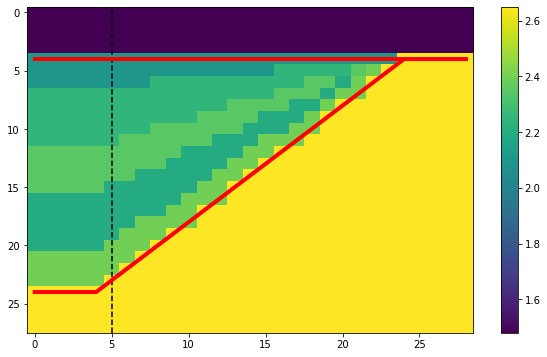

In [15]:
w, top, base, ref = wedge(depth=(4., 20, 4),
                          width=(4, 21, 4),
                          strat=(1.48, (2.10, 2.25, 2.35, 2.20, 2.40), 2.65),
                          thickness=(1, 0),
                          mode='linear',
                         )

plt.figure(figsize=(10, 6))
plt.imshow(w, aspect='auto', interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)
plt.colorbar()

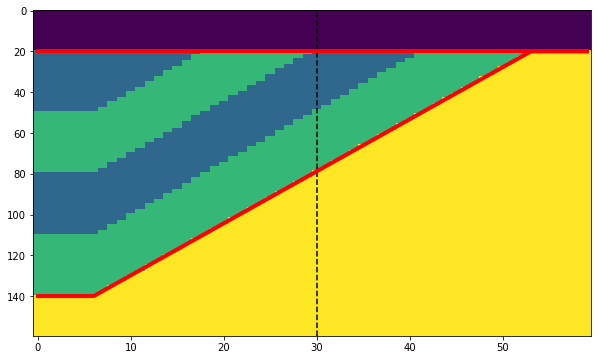

In [16]:
w, top, base, ref = wedge(depth=(20, 60, 20),
                          width=61,
                          strat=(0, (1,2), 3),
                          mode='linear',
                          conformance='bottom',
                          thickness=(2, 0)
                         )

plt.figure(figsize=(10, 6))
plt.imshow(w, aspect='auto', interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)

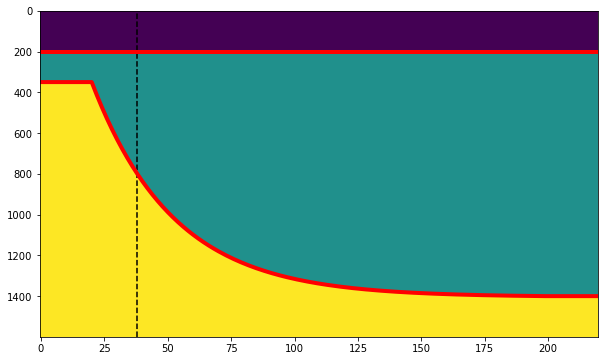

In [17]:
w, top, base, ref = wedge(depth=(200, 600, 200), width=(20, 180, 20),
                          strat=(0, 1, 2),
                          thickness=(0.25, 2),
                          mode='power'
                         )

plt.figure(figsize=(10, 6))
plt.imshow(w, aspect='auto', interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)

In [23]:
layer2 = [1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1]

w, top, base, ref = wedge(depth=(20, 120, 20),
                          width=(20, 180, 20),
                          breadth=80,
                          strat=(0, layer2, 3),
                          thickness=(0, 1),
                          mode='linear',
                          conformance='both'
                         )

w.shape

(160, 220, 80)

(0.0, 1.0, 0.0, 1.0)

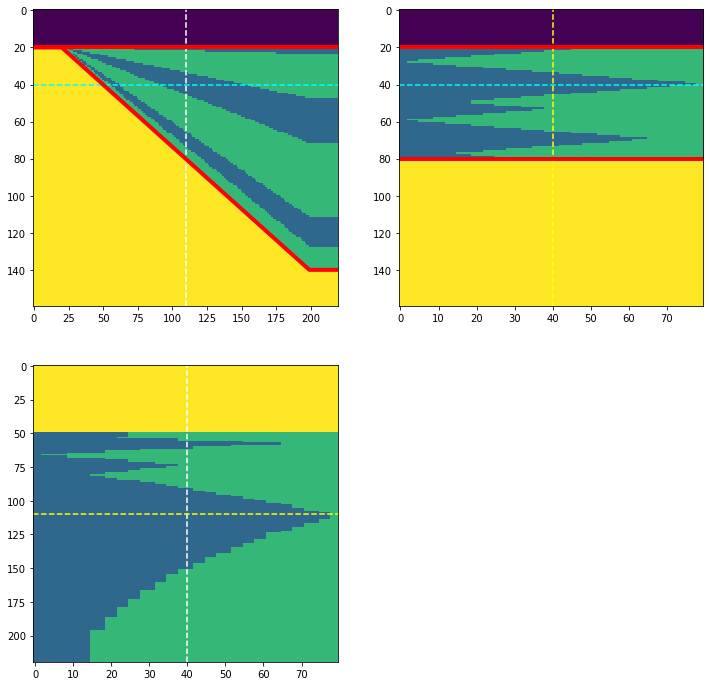

In [34]:
fig, axs = plt.subplots(figsize=(12, 12), ncols=2, nrows=2)

line = 40
xline = 110
slic = 40

ax = axs[0, 0]
ax.imshow(w[:, :, line], aspect='auto', interpolation='none')
ax.axvline(xline, color='white', ls='--')
#ax.axvline(ref, color='k', ls='--')
ax.axhline(slic, color='cyan', ls='--')
ax.plot(top[:, line], 'r-', lw=4)
ax.plot(base[:, line], 'r-', lw=4)

ax = axs[0, 1]
ax.imshow(w[:, xline], aspect='auto', interpolation='none')
ax.axhline(slic, color='cyan', ls='--')
ax.axvline(line, color='yellow', ls='--')
ax.plot(top[xline], 'r-', lw=4)
ax.plot(base[xline], 'r-', lw=4)

ax = axs[1, 0]
ax.imshow(w[slic], interpolation='none', aspect='auto', vmin=0)
ax.axvline(line, color='white', ls='--')
ax.axhline(xline, color='yellow', ls='--')

ax = axs[1, 1]
ax.axis('off')

---

## With well data

In [ ]:
from welly import Well

w = Well.from_las('../data/R-39.las')

log, top, bot = 'GR', 2620, 2625

log_before = w.data[log].to_basis(stop=top)
log_wedge = w.data[log].to_basis(start=top, stop=bot)
log_after = w.data[log].to_basis(start=bot)

In [20]:
log_before.shape, log_wedge.shape, log_after.shape

((2802,), (33,), (5008,))

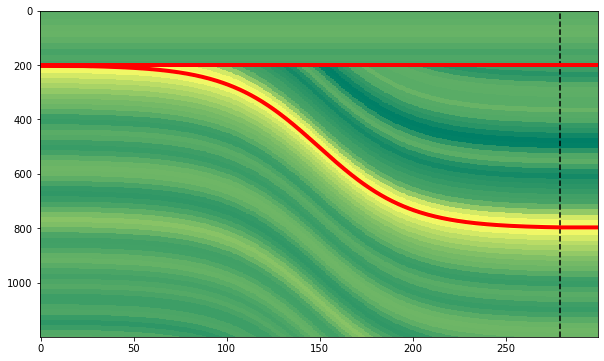

In [21]:
w, top, base, ref = wedge(depth=(200, 600, 400),
                          width=(20, 260, 20),
                          strat=(log_before, log_wedge, log_after),
                          mode='sigmoid', conformance='bottom',
                          thickness=(0, 1)
                         )

plt.figure(figsize=(10, 6))
plt.imshow(w, aspect='auto', cmap='summer_r', interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)

---
&copy; 2021 Agile Scientific, licensed CC-BY / Apache 2.0